# Car Price Prediction


Install packages


In [1]:
!uv pip install -q \
    python-dotenv==1.2.1 \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2 \
    scikit-learn==1.7.1

Append notebooks directory to sys.path


In [ ]:
import sys

sys.path.append("../../..")

Import packages


In [3]:
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dotenv import load_dotenv

from notebooks.python.utils.data_extraction.data_extraction import (
    KaggleDataExtractor,
    KaggleExtractionConfig,
)

pd.set_option("display.max_columns", None)

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

%matplotlib inline

load_dotenv()  # Root directory .env file

True

## Utility scripts:

**KaggleDataExtractor**:

```py
--8<-- "docs/notebooks/python/utils/data_extraction/data_extraction.py"
```


Create data directory


In [ ]:
DATA_DIR = pathlib.Path("data/predicting-car-price")

os.makedirs(DATA_DIR, exist_ok=True)

Download dataset from Kaggle


In [ ]:
username = os.getenv("KAGGLE_USERNAME")
api_token = os.getenv("KAGGLE_API_TOKEN")
file_name = "data.csv"

extractor = KaggleDataExtractor(username=username, api_token=api_token)

config = KaggleExtractionConfig(
    dataset_slug="CooperUnion/cardataset",
    file_name=file_name,
    destination_path=DATA_DIR,
    output_file_name="cars.csv",
)

extractor.download_dataset(config)

2025-11-30 11:07:43 | INFO     | KaggleExtractor | Starting download from Kaggle: https://www.kaggle.com/api/v1/datasets/download/CooperUnion/cardataset
2025-11-30 11:07:44 | INFO     | KaggleExtractor | Download completed. Extracting zip file...
2025-11-30 11:07:44 | INFO     | KaggleExtractor | Dataset 'data.csv' extracted successfully to: data/predicting-car-price


## Data Preparation


Load dataset


In [ ]:
df = pd.read_csv(DATA_DIR / "cars.csv")

df.head(n=2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


Clean column names


In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.head(n=2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


Inspect DataFrame types


In [ ]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

Select only object type columns


In [ ]:
object_type_columns = list(df.dtypes[df.dtypes == "object"].index)

Clean column values


In [ ]:
object_type_columns = list(df.dtypes[df.dtypes == "object"].index)
for column in object_type_columns:
    df[column] = df[column].str.lower().str.replace(" ", "_")

## Exploratory Data Analysis


Column summary


In [ ]:
df_summary = pd.DataFrame(
    {
        "column": df.columns,
        "dtype": [df[col].dtype for col in df.columns],
        "sample_unique": [df[col].unique()[:6] for col in df.columns],
        "n_unique": [df[col].nunique() for col in df.columns],
    }
)
df_summary

,column,dtype,sample_unique,n_unique
0,make,object,"[bmw, audi, fiat, mercedes-benz, chrysler, nis...",48
1,model,object,"[1_series_m, 1_series, 100, 124_spider, 190-cl...",914
2,year,int64,"[2011, 2012, 2013, 1992, 1993, 1994]",28
3,engine_fuel_type,object,"[premium_unleaded_(required), regular_unleaded...",10
4,engine_hp,float64,"[335.0, 300.0, 230.0, 320.0, 172.0, 160.0]",356
5,engine_cylinders,float64,"[6.0, 4.0, 5.0, 8.0, 12.0, 0.0]",9
6,transmission_type,object,"[manual, automatic, automated_manual, direct_d...",5
7,driven_wheels,object,"[rear_wheel_drive, front_wheel_drive, all_whee...",4
8,number_of_doors,float64,"[2.0, 4.0, 3.0, nan]",3
9,market_category,object,"[factory_tuner,luxury,high-performance, luxury...",71


Price distribution


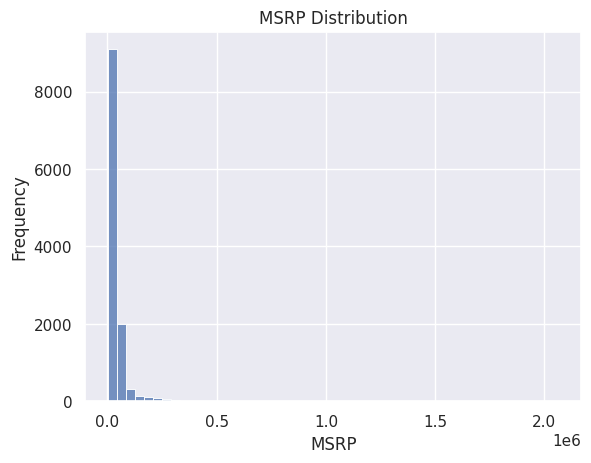

In [ ]:
sns.histplot(data=df.msrp, bins=50)
plt.title("MSRP Distribution")
plt.xlabel("MSRP")
plt.ylabel("Frequency")
plt.show()

A long tail distribution is observed, with a few cars priced very high.


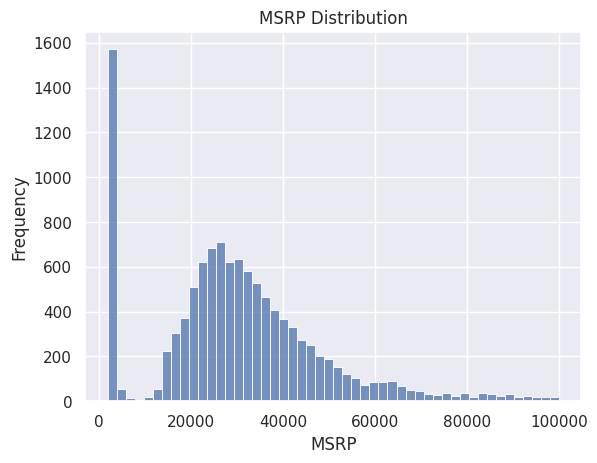

In [ ]:
# 1e6 = 1,000,000
sns.histplot(data=df.msrp[df.msrp < 100000], bins=50)
plt.title("MSRP Distribution")
plt.xlabel("MSRP")
plt.ylabel("Frequency")
plt.show()

Convert to log scale to reduce skewness, when doing an Machine Learning model, a skewed target variable can lead to suboptimal model performance.


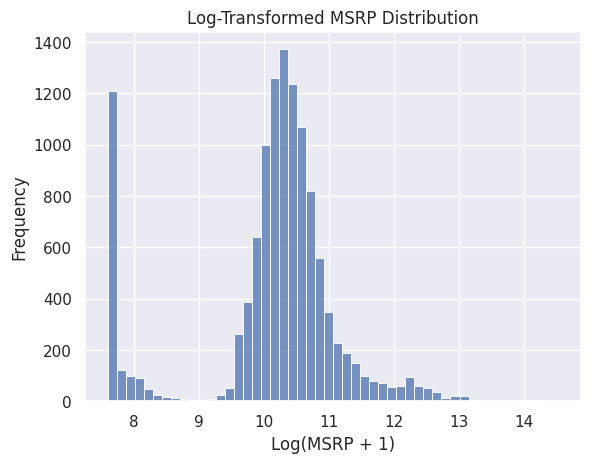

In [ ]:
price_log = np.log1p(df.msrp)  # sum of 1 to avoid log(0)
sns.histplot(data=price_log, bins=50)
plt.title("Log-Transformed MSRP Distribution")
plt.xlabel("Log(MSRP + 1)")
plt.ylabel("Frequency")
plt.show()

Missing values


In [ ]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## Validation Framework


Set split sizes

- Training dataset: 60%
- Validation dataset: 20%
- Test dataset: 20%


In [ ]:
dataframe_size = len(df)
validation_size = int(dataframe_size * 0.2)
test_size = int(dataframe_size * 0.2)
train_size = int(dataframe_size - validation_size - test_size)

validation_size, test_size, train_size

(2382, 2382, 7150)

Split DataFrame into train, validation and test sizes


In [ ]:
df_index = np.arange(dataframe_size)

np.random.seed(2)  # make reproducible
np.random.shuffle(df_index)

df_train = df.iloc[df_index[:train_size]]
df_validation = df.iloc[df_index[train_size : train_size + validation_size]]
df_test = df.iloc[df_index[train_size + validation_size :]]

df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


len(df_train), len(df_validation), len(df_test)

(7150, 2382, 2382)

In [ ]:
df_train.head(n=2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,14410
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,19685


Define prediction target


In [ ]:
y_train = np.log1p(df_train.msrp.values)
y_validation = np.log1p(df_validation.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [ ]:
df_train.drop(columns=["msrp"], inplace=True, errors="ignore")
df_validation.drop(columns=["msrp"], inplace=True, errors="ignore")
df_test.drop(columns=["msrp"], inplace=True, errors="ignore")

"msrp" in df_train.columns, "msrp" in df_validation.columns, "msrp" in df_test.columns

(False, False, False)

## Linear Regression
